In [1]:
from collections import defaultdict
import itertools as itt
import pathlib as pl
from configparser import ConfigParser

import pandas as pd
from IPython.display import Image

import joblib as jl
import numpy as np
import scipy.stats as sst
from scikit_posthocs import posthoc_dunn
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from webcolors import name_to_hex

from src.root_path import config_path, root_path
from src.utils.dataframes import add_classified_contexts
from src.utils.tools import decimate_xy
from src.visualization.palette import *

# context metric distribution and comparison between regions and transition pairs
### Load and format all required data, i.e. a dataframe

In [2]:
config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))
meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 20,
        'zscore': True,
        'stim_type': 'permutations',
        }
alpha = 0.05
montecarlos = 11000

folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)

summary_DF_file = pl.Path(config['paths']['analysis_cache']) / '220520_minimal_DF'

In [3]:
def print_percentage_significant():
    DF = jl.load(summary_DF_file).query(
        "analysis == 'SC' and mult_comp_corr == 'bf_cp' and metric in 'integral' "
        )
    # number proportion of significant instances
    nsignif = np.sum(DF.value.values>0)
    ntotal  = DF.shape[0]
    print(f'{nsignif}/{ntotal}, {nsignif/ntotal*100:.3f}% significant  instances')

    # proportion of neurons with at least one signif instance
    neusig = DF.groupby('id').agg(modulated=('value', lambda x: np.any(x>0)))
    nsignif = np.sum(neusig.modulated.values)
    ntotal  = neusig.shape[0]
    print(f'{nsignif}/{ntotal}, {nsignif/ntotal*100:.3f}% modulated neurons')

print_percentage_significant()

45906/501440, 9.155% significant  instances
1232/2728, 45.161% modulated neurons


In [4]:
# Cluster Mass significant contextual effects
# summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'

metrics = ['integral', 'last_bin']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and source == 'real' and "
                                    f"diff_metric == 'delta_FR' and "
                                    f"value > 0")

DF.loc[DF.metric == 'integral', 'value'] = DF.loc[DF.metric == 'integral', 'value'] /1000  # ms to s for better display

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)
DF = add_classified_contexts(DF)

for col in ['id','context_pair','probe','site', 'region', 'metric', 'trans_pair']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
print(DF.shape)
print(DF.head())


# pivots for the scatter
pivoted = DF.pivot_table(index=['region', 'site', 'context_pair', 'probe', 'trans_pair', 'id'],
                         columns=['metric'], values='value', aggfunc='first', observed=True).reset_index()

# adds a small amount of jitter to the last bin value to help visualization
binsize = 1 / meta['raster_fs']
jitter = (np.random.random(pivoted.shape[0]) * binsize * 0.8 - (binsize * 0.8 / 2)) * 1000  # in ms
pivoted['last_bin_jittered'] = pivoted['last_bin'] + jitter

print(pivoted.shape)
print(pivoted.head())

(91812, 9)
              id context_pair probe     value    metric diff_metric     site  \
0  TNC013a-019-3        00_01     1  0.181284  integral    delta_FR  TNC013a   
1  TNC013a-036-3        00_01     1  0.337167  integral    delta_FR  TNC013a   
2  TNC013a-042-9        00_01     1  0.192177  integral    delta_FR  TNC013a   
3  TNC013a-046-1        00_01     1  0.134207  integral    delta_FR  TNC013a   
4  TNC013a-036-3        00_02     1  0.346280  integral    delta_FR  TNC013a   

  region    trans_pair  
0     A1  same_silence  
1     A1  same_silence  
2     A1  same_silence  
3     A1  same_silence  
4     A1  diff_silence  
(45906, 9)
metric region     site context_pair probe    trans_pair             id  \
0          A1  TNC013a        00_01     1  same_silence  TNC013a-019-3   
1          A1  TNC013a        00_01     1  same_silence  TNC013a-036-3   
2          A1  TNC013a        00_01     1  same_silence  TNC013a-042-9   
3          A1  TNC013a        00_01     1  same_sil

# Panels

In [5]:
panels = defaultdict(list)

## scatter plot of all dots

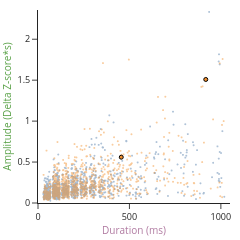

In [6]:
panelname = 'scater_full'
if panelname in panels:
    panels.pop(panelname)

maxy = list()
rng = np.random.default_rng(42)
for region in ['A1', 'PEG']:
    toplot = pivoted.query(f"region == '{region}'")
    x = toplot['last_bin_jittered'].values
    y = toplot['integral'].values

    xm, ym = decimate_xy(x, y, end_num=1000, by_quantiles=False, rng=rng)
    maxy.append(np.max(ym))

    panels[panelname].append(go.Scatter(x=xm, y=ym,
                                          mode='markers',
                                          opacity=0.5,
                                          marker=dict(
                                              color=REGION_COLORMAP[region],
                                              opacity=0.9,
                                              size=2
                                          ),
                                          name=region,
                                          hoverinfo='skip',
                                          showlegend=False)
                             )

maxy = np.max(maxy)

## highlight the special cell, defined in the first cell of the notebook
# same examples as in figure 1, cellid, (context-pair,), probe
example_cells = [
    ('ARM021b-36-8', (0,1), 3),
    ('ARM021b-36-8', (1,3), 4),
]

for cellid, ctx_pair, probe in example_cells:

    celltoplot = toplot.query(f"id == '{cellid}' and context_pair == '{ctx_pair[0]:02}_{ctx_pair[1]:02}' and "
                              f"probe == {probe}")

    panels[panelname].append(go.Scatter(x=celltoplot['last_bin_jittered'],
                                          y=celltoplot["integral"],
                                          mode='markers',
                                          marker=dict(color=REGION_COLORMAP[celltoplot['region'].values[0]],
                                                      size=4,
                                                      line=dict(color='black',
                                                                width=1)),
                                          hoverinfo='skip',
                                          showlegend=False)
                             )

fig = go.Figure()
pan = panels[panelname]
fig.add_traces(pan)

w, h = 2.5, 2.5 # in inches
_ = fig.update_layout(template='simple_white',
                      margin=dict(l=10, r=10, t=10, b=10),
                      width=round(96*w), height=round(96*h),

                      xaxis=dict(
                          range=[0, 1050],
                          title=dict(
                          text='Duration (ms)',
                          standoff=0,
                          font_color=DURCOLOR,
                          font_size=10),
                          tickfont_size=9
                      ),

                      yaxis=dict(
                          range=[0,maxy+maxy*0.01],
                                 title=dict(
                          text="Amplitude (Delta Z-score*s) ",
                          standoff=0,
                          font_color=AMPCOLOR,
                          font_size=10),
                          tickfont_size=9
                      ))


filename = folder / 'fig2_parameter_scatter'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96*w, height=96*h, scale=1)
Image(img_bytes)

In [7]:
# count number of instances that are being compared, their mean and standard deviations
inst_by_reg = pivoted.groupby('region', observed=True).agg(inst_count=('integral', 'count'), neu_count=('id', pd.Series.nunique))
print(inst_by_reg)


inst_by_trans = pivoted.groupby('trans_pair', observed=True).agg(inst_count=('integral', 'count'), neu_count=('id', pd.Series.nunique))
print('\n', inst_by_trans)
print('\n',inst_by_reg.sum())


        inst_count  neu_count
region                       
A1           24711        709
PEG          21195        523

               inst_count  neu_count
trans_pair                         
same_silence        1766        725
diff_silence       11242       1019
diff_same           7657        945
diff_diff          25241        991

 inst_count    45906
neu_count      1232
dtype: int64


In [8]:
reg_summary = DF.groupby(['region', 'metric'], observed=True).agg(
    mean=('value', np.mean), std=('value', np.std), sem=('value', sst.sem))
trans_summary = DF.groupby(['trans_pair', 'metric'], observed=True).agg(
    mean=('value', np.mean), std=('value', np.std), sem=('value', sst.sem))
full_summary = DF.groupby(['metric'], observed=True).agg(
    mean=('value', np.mean), std=('value', np.std), sem=('value', sst.sem))

print(reg_summary)
print(trans_summary)
print(full_summary)

                       mean         std       sem
region metric                                    
A1     integral    0.226451    0.177054  0.001126
       last_bin  244.965805  213.253093  1.356595
PEG    integral    0.248110    0.202874  0.001394
       last_bin  254.246292  203.175906  1.395582
                             mean         std       sem
trans_pair   metric                                    
same_silence integral    0.259122    0.225448  0.005365
             last_bin  284.852783  242.493318  5.770380
diff_silence integral    0.275534    0.241165  0.002275
             last_bin  285.936676  237.012360  2.235369
diff_same    integral    0.217695    0.164312  0.001878
             last_bin  238.174225  200.860764  2.295439
diff_diff    integral    0.223148    0.163756  0.001031
             last_bin  233.780350  192.070902  1.208950
                mean         std       sem
metric                                    
integral    0.236451    0.189718  0.000885
last_bin  2

### formate strigs to copy paste into paper

In [9]:
# metrics by region
toprint = reg_summary.swaplevel(0,1)
for metric in toprint.index.levels[0]:
    inner = reg_summary.swaplevel(0,1).loc[metric,:]
    str_parts = list()
    for tp, vals in inner.iterrows():
        str_parts.append(f"{tp}: {vals.loc['mean']:.2f}±{vals.loc['sem']:.2f}")

    if metric == 'integral':
        units = 'Z-score*s'
    elif metric == 'last_bin':
        units = 'ms'

    full_str = f'{metric} mean±SEM. ' + ', '.join(str_parts) + units
    print(full_str)

integral mean±SEM. A1: 0.23±0.00, PEG: 0.25±0.00Z-score*s
last_bin mean±SEM. A1: 244.97±1.36, PEG: 254.25±1.40ms


In [10]:
# metrics by context pair
toprint = trans_summary.swaplevel(0,1)
for metric in toprint.index.levels[0]:
    inner = trans_summary.swaplevel(0,1).loc[metric,:]
    str_parts = list()
    for tp, vals in inner.iterrows():
        str_parts.append(f"{tp}: {vals.loc['mean']:.2f}±{vals.loc['sem']:.2f}")

    if metric == 'integral':
        units = 'Z-score*s'
    elif metric == 'last_bin':
        units = 'ms'

    full_str = f'{metric} mean±SEM. ' + ', '.join(str_parts) + units
    print(full_str)

integral mean±SEM. same_silence: 0.26±0.01, diff_silence: 0.28±0.00, diff_same: 0.22±0.00, diff_diff: 0.22±0.00Z-score*s
last_bin mean±SEM. same_silence: 284.85±5.77, diff_silence: 285.94±2.24, diff_same: 238.17±2.30, diff_diff: 233.78±1.21ms


# simpliffied summary plots

In [11]:
# grand mean across all data, works to normalize metrics across all data, and transform units from
# integral (z-score * ms) into percentage increase in firing rate.
def norm_by_mean(df):
    normalizer =df.groupby(by=['metric'], observed=True).agg(grand_mean=('value',np.mean)).reset_index()

    df = pd.merge(df, normalizer, on=['metric'], validate="m:1")
    df['norm_val'] = df['value']/df['grand_mean']

    return df

def simplify_classified_contexts(df):
    # the simplest approach is to manually map the 4 categories into onehots
    # onehot order: diff1 diff2 same silence
    # mapper={'diff_diff':(1,1,0,0), 'diff_same':(1,0,1,0), 'diff_silence':(1,0,0,1), 'same_silence':(0,0,1,1)}

    # even simpler encoding
    # onehot order: diff(1 and 2) same silence
    mapper={'diff_diff':(1,0,0), 'diff_same':(1,1,0), 'diff_silence':(1,0,1), 'same_silence':(0,1,1)}

    df['onehot'] = df['trans_pair'].replace(mapper)

    # onehotdf = pd.DataFrame(toregress['onehot'].to_list(), columns = ['diff1', 'diff2', 'same', 'silence'])
    onehotdf = pd.DataFrame(df['onehot'].to_list(), columns = ['diff', 'same', 'silence'])
    df.drop(columns='onehot', inplace=True)
    df = pd.concat([df, onehotdf], axis=1)

    return df

In [12]:
def kruskal_with_posthoc(df, group_col, val_col):
    # pools data in a list of vectors to run kruskal
    to_stat = list()
    for kk in df[group_col].unique():
        to_stat.append(df.loc[df[group_col] == kk, val_col].values)
    kruskal = sst.kruskal(*to_stat)
    print(kruskal)

    # uses the og dataframe to run the pairwise posthoc test
    dunn = posthoc_dunn(df, val_col=val_col, group_col=group_col, p_adjust='bonferroni')
    print(f'Dunn post hoc results\n{dunn}')

    return kruskal, dunn

              id context_pair probe     value    metric diff_metric     site  \
0  TNC013a-019-3        00_01     1  0.181284  integral    delta_FR  TNC013a   
1  TNC013a-036-3        00_01     1  0.337167  integral    delta_FR  TNC013a   
2  TNC013a-042-9        00_01     1  0.192177  integral    delta_FR  TNC013a   
3  TNC013a-046-1        00_01     1  0.134207  integral    delta_FR  TNC013a   
4  TNC013a-036-3        00_02     1  0.346280  integral    delta_FR  TNC013a   

  region    trans_pair  grand_mean  norm_val  diff  same  silence  
0     A1  same_silence    0.236451  0.766689     0     1        1  
1     A1  same_silence    0.236451  1.425949     0     1        1  
2     A1  same_silence    0.236451  0.812757     0     1        1  
3     A1  same_silence    0.236451  0.567587     0     1        1  
4     A1  diff_silence    0.236451  1.464489     1     0        1  
              id context_pair probe     value    metric diff_metric     site  \
4  TNC013a-036-3        00_02  

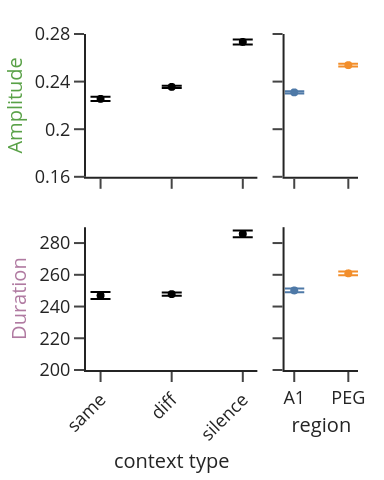

In [33]:
toregress = norm_by_mean(DF)
toregress = simplify_classified_contexts(toregress)

print(toregress.head())

toplot = list()  # concatenate data classified on single values
for cat in ['diff', 'same', 'silence']:
    subset = toregress.query(f"{cat} == 1").copy()
    subset['transition'] = cat
    toplot.append(subset)

toplot = pd.concat(toplot)
print(toplot.head())


def plot_metric_quant_bars(df, metric, category):
    print(f'\n######### {metric}, {category} #########\n')
    df = df.query(f"metric == '{metric}'")

    if category == 'transition':
        ### transitions ###
        _ = kruskal_with_posthoc(df, group_col='transition', val_col='value')
        df = df.groupby(by=['transition'], observed=True).agg(stat=('value', np.mean),
                                                              err=('value', sst.sem))

        x = ['same', 'diff', 'silence']
        y = [df.at[cat, 'stat'] for cat in x]
        yerr = [df.at[cat, 'err'] for cat in x]
        return [
            go.Scatter(x=x, y=y, mode='markers',
                       marker=dict(color='black',
                                   size=4),
                       error_y=dict(array=yerr,
                                    color='black',
                                    thickness=1,
                                    width=5),
                       showlegend=False)
        ]

    ### regions ###
    elif category == 'region':
        _ = kruskal_with_posthoc(df, group_col='region', val_col='value')
        df = df.groupby('region').agg(stat=('value', np.mean),
                                      err=('value', sst.sem))

        # if you want different color error bars, have to do it one at a time
        reg_quant = list()
        for rr, row in df.iterrows():
            reg_quant.append(go.Scatter(x=(rr,),
                                        y=(row.stat,),
                                        mode='markers',
                                        marker=dict(color=REGION_COLORMAP[rr],
                                                    size=4),
                                        error_y=dict(array=(row.err,),
                                                     color=REGION_COLORMAP[rr],
                                                     thickness=1,
                                                     width=5),
                                        showlegend=False),
                             )

        return reg_quant
    else:
        raise ValueError(f'bad param {category}')


fig = make_subplots(2, 2, column_width=[0.7, 0.3], shared_xaxes='columns', shared_yaxes='rows')
for mm, met in enumerate(['integral', 'last_bin']):
    for cc, cat in enumerate(['transition', 'region']):
        pan = plot_metric_quant_bars(toplot, met, cat)
        fig.add_traces(pan, cols=[cc + 1] * len(pan), rows=[mm + 1] * len(pan))

        # legacy shit
        panelname = f'{met}_{cat}_simple'
        if panelname in panels:
            panels.pop(panelname)
        panels[panelname].extend(pan)

w, h = 2, 2.5
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(l=10, r=10, t=10, b=10),

                  yaxis=dict(title=dict(text="Amplitude", font_color=AMPCOLOR, ),
                             # range=[0, 0.28]
                             range=[0.16, 0.28],
                             tickmode='linear', tick0=0.16, dtick=0.04
                             ),
                  yaxis2=dict(
                             tickmode='linear', tick0=0.16, dtick=0.04
                             ),

                  xaxis3=dict(title=dict(text='context type'), tickangle=-45),
                  yaxis3=dict(title=dict(text='Duration', font_color=DURCOLOR),
                              # range=[0, 290]
                              range=[200, 290]
                              ),

                  xaxis4=dict(title=dict(text='region')),
                  showlegend=False,
                  )

fig.update_xaxes(title_font_size=10, title_standoff=0, tickfont_size=9)
fig.update_yaxes(title_font_size=10, title_standoff=0, tickfont_size=9)

folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)

filename = folder / 'fig2_transition_region_effects'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", scale=2)
Image(img_bytes)

## barplots of statistical analysis
this has been deprecated for the prior simpliffied analysis which pools contexts together, instead of comparing raw
context pairs

In [15]:
tocalc = DF.query(f"metric == '{metric}' and value > 0")
tocalc = tocalc.replace({'silence_diff': 'sile_diff', 'silence_same': 'sile_same'})
toplot = tocalc.groupby('region', observed=True).agg(stat=('value', np.mean),
                                      err=('value', sst.sem))



In [16]:
for rr, row in toplot.iterrows():
    print(row.name)
    print(row.stat)
    print(row.err)

A1
244.96580505371094
1.3565948269477581
PEG
254.2462921142578
1.3955824161460173


integral, transition
same_silence vs diff_silence MannwhitneyU 0.0011389569800773127
same_silence vs diff_same MannwhitneyU 3.543816926117258e-16
same_silence vs diff_diff MannwhitneyU 8.94675697320587e-12
diff_silence vs diff_same MannwhitneyU 6.807467292041384e-82
diff_silence vs diff_diff MannwhitneyU 7.713992954570768e-98
diff_same vs diff_diff MannwhitneyU 0.00010727920586157257
integral, region
A1 vs PEG MannwhitneyU 1.7401457284346878e-22
last_bin, transition
same_silence vs diff_silence MannwhitneyU 0.18031642401512177
same_silence vs diff_same MannwhitneyU 6.264932159981433e-11
same_silence vs diff_diff MannwhitneyU 3.897591346390831e-13
diff_silence vs diff_same MannwhitneyU 2.63530575799983e-40
diff_silence vs diff_diff MannwhitneyU 6.462975388338908e-72
diff_same vs diff_diff MannwhitneyU 0.36256695857438914
last_bin, region
A1 vs PEG MannwhitneyU 4.8865007347239515e-31


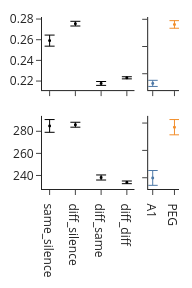

In [17]:
# for metric in ["integral", "last_bin"],:
def plot_metric_quant_bars(metric, category):
    print(f'{metric}, {category}')
    tocalc = DF.query(f"metric == '{metric}' and value > 0")
    tocalc = tocalc.replace({'silence_diff': 'sile_diff', 'silence_same': 'sile_same'})

    if category == 'transition':
        ### transitions ###
        toplot = tocalc.groupby('trans_pair', observed=True).agg(stat=('value', np.mean),
                                                  err=('value', sst.sem))

        for c0,c1 in itt.combinations(tocalc.trans_pair.unique().tolist(), 2):
            x = tocalc.loc[tocalc.trans_pair == c0, 'value'].values.astype(float)
            y = tocalc.loc[tocalc.trans_pair == c1, 'value'].values.astype(float)
            stat, pval = sst.mannwhitneyu(x,y)
            print(f'{c0} vs {c1} MannwhitneyU {pval}')

        return [
            go.Scatter(x=toplot.index, y=toplot['stat'], mode='markers',
                       marker=dict(color='black',
                                   size=3),
                       error_y=dict(array=toplot['err'],
                                    color=name_to_hex('black'),
                                    thickness=1,
                                    width=5),
                       showlegend=False)
        ]

    ### regions ###
    elif category == 'region':
        x = tocalc.loc[tocalc.region == 'A1', 'value'].values.astype(float)
        y = tocalc.loc[tocalc.region == 'PEG', 'value'].values.astype(float)
        stat, pval = sst.mannwhitneyu(x,y)
        print(f'A1 vs PEG MannwhitneyU {pval}')

        toplot = tocalc.groupby('region', observed=True).agg(stat=('value', np.mean),
                                              err=('value', sst.sem))

        # if you want different color error bars, have to do it one at a time
        reg_quant = list()
        for rr, row in toplot.iterrows():
            reg_quant.append(go.Scatter(x=(row.name,),
                                        y=(row.stat,),
                                        mode='markers',
                                        marker=dict(color=REGION_COLORMAP[row.name],
                                                    size=3),
                                        error_y=dict(array=(row.err,),
                                                     color=REGION_COLORMAP[row.name],
                                                     thickness=1,
                                                     width=5),
                                        showlegend=False),
                             )

        return reg_quant
    else:
        raise ValueError(f'bad param {category}')

fig = make_subplots(2,2, column_width=[0.75,0.25])
for mm, met in enumerate(['integral', 'last_bin']):
    for cc, cat in enumerate(['transition', 'region']):

        panelname = f'{met}_{cat}'

        if panelname in panels:
            panels.pop(panelname)

        panels[panelname].extend(plot_metric_quant_bars(met, cat))


        pan = panels[panelname]
        fig.add_traces(pan, cols=[cc+1]*len(pan), rows=[mm+1]*len(pan))


fig.update_layout(template='simple_white',
                  width=96*2, height=96*3,
                  margin=dict(l=10, r=10, t=10, b=10),
                  xaxis=dict(showticklabels=False),
                  xaxis2=dict(showticklabels=False),
                  yaxis2=dict(showticklabels=False),
                  yaxis4=dict(showticklabels=False),
                  )

img_bytes = fig.to_image(format="png")
Image(img_bytes)

# merges all the parts in a single figure

In [18]:
# simple plot layout and other figurewide configurations

def define_subplots():
    fig = make_subplots(rows=2,cols=3, vertical_spacing=0.05, horizontal_spacing=0.05,
                        column_widths=[0.6, 0.3, 0.1],
                        specs=[[{'rowspan':2, 'r':0.1}, {}, {}],
                               [None                  , {}, {}]])
    # figure size in inches at different PPIs
    ppi = 96 # www standard

    heigh = 3
    width = 4 # in inches
    _ = fig.update_layout(template='simple_white',
                          margin=dict(l=10, r=10, t=10, b=10),
                          width=round(ppi*width), height=round(ppi*heigh),

                          xaxis=dict(title=dict(
                              text='Last bin (ms)',
                              standoff=0,
                              font_color=DURCOLOR)
                          ),

                          yaxis=dict(title=dict(
                              text="Integral (T-score*ms)",
                              standoff=0,
                              font_color=AMPCOLOR)
                          ),

                          xaxis2=dict(matches='x4',showticklabels=False),

                          yaxis2=dict(title=dict(
                              text="Amplitude",
                              font_color=AMPCOLOR,
                              standoff=0)
                          ),

                          xaxis3=dict(matches='x5',showticklabels=False),

                          yaxis3=dict(matches='y2',showticklabels=False),

                          xaxis4=dict(title=dict(text='context type pair', standoff=0), tickangle=-45,),

                          yaxis4=dict(title=dict(text='Duration', font_color=DURCOLOR, standoff=0)),

                          xaxis5=dict(title=dict(text='region', standoff=39)),

                          yaxis5=dict(matches='y4',showticklabels=False),

                          showlegend=False,
                          font_size=10,
                          )

    # add letter annotations for subplots
    anotations = [
        ('a', 0, 1),
        ('b', 0.5, 1),
        ('c', 0.87, 1),
        ('d', 0.5, 0.5),
        ('e', 0.87, 0.5),
    ]

    for letter, x, y in anotations:
        fig.add_annotation(x=x, y=y,
                           text=f'<b>{letter}</b>', font_size=12,
                           xref='paper', yref='paper',
                           xanchor='center', yanchor='middle',
                           showarrow=False)


    return fig, round(ppi*width), round(ppi*heigh)

f, pw, ph = define_subplots()
f.print_grid()
# img_bytes = f.to_image(format="png", width=pw, height=ph)
# Image(img_bytes)

This is the format of your plot grid:
⎡ (1,1) x,y   ⎤  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
⎣      :      ⎦  [ (2,2) x4,y4 ]  [ (2,3) x5,y5 ]



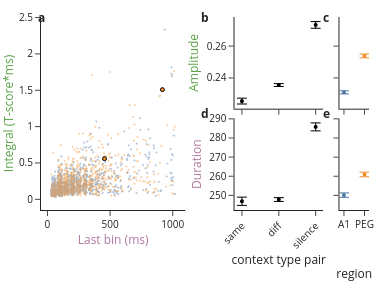

In [19]:
fig, pw, ph = define_subplots()

# scatter
pan = panels['scater_full']
fig.add_traces(pan, cols=[1]*len(pan), rows=[1]*len(pan))

# top left
# pan = panels['integral_transition']
pan = panels['integral_transition_simple']
fig.add_traces(pan, cols=[2]*len(pan), rows=[1]*len(pan))

# top right
# pan = panels['integral_region']
pan = panels['integral_region_simple']
fig.add_traces(pan, cols=[3]*len(pan), rows=[1]*len(pan))

# bottom left
# pan = panels['last_bin_transition']
pan = panels['last_bin_transition_simple']
fig.add_traces(pan, cols=[2]*len(pan), rows=[2]*len(pan))

# bottom right
# pan = panels['last_bin_region']
pan = panels['last_bin_region_simple']
fig.add_traces(pan, cols=[3]*len(pan), rows=[2]*len(pan))


img_bytes = fig.to_image(format="png", width=pw, height=ph)
Image(img_bytes)

# saves PNG and SVG

In [20]:
filename = folder / 'figure_02'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))